# Homework 2 Evolutionary Algorithms.
This file will include all the necessary code for evolutionary algorithm homework. The task is described as "In this homework, you will perform experiments on evolutionary algorithm and draw conclusions from the experimental results. The task is to create an image made of filled circles, visually similar to a given RGB source image (painting.png)"

## Pseudo code
Initialize population with <num_inds> individuals each having <num_genes> genes
While not all generations (<num_generations>) are computed:
Evaluate all the individuals
Select individuals
Do crossover on some individuals
Mutate some individuals

In [15]:
# "Individual" class definition for evolutionary algoritm. There will be on chromosome and N number of genes. Each gene will have center coordinates (x,y), Radius, and RGB color.

import random
import math
import numpy as np
import cv2

class Individual:
    def __init__(self, num_genes, image_size):
        self.num_genes = num_genes
        self.image_size = image_size
        self.chromosome = []
        self.fitness = np.float128(0.0)
        self.elite = False
        self.radius_max = image_size[0]//4

        for i in range(num_genes):
            x = random.randint(-1*self.radius_max, self.image_size[0]+1*self.radius_max)
            y = random.randint(-1*self.radius_max, self.image_size[1]+1*self.radius_max)
            r = random.randint(1, self.radius_max)
            color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
            alpha = random.random()

            self.chromosome.append([x, y, r, color, alpha])

    def mutate(self, mutation_probability, guidance = None):
        if not self.elite:
            if guidance is None:
                for i in range(self.num_genes):
                    if random.random() < mutation_probability:
                        self.chromosome[i][0] = random.randint(-1*self.radius_max, self.image_size[0]+1*self.radius_max)
                        self.chromosome[i][1] = random.randint(-1*self.radius_max, self.image_size[1]+1*self.radius_max)
                        self.chromosome[i][2] = random.randint(1, self.radius_max*2)
                        self.chromosome[i][3] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
            else:
                #Guided mutation, deviate x,y, radius, color and alpha around their previous values
                for i in range(self.num_genes):
                    if random.random() < mutation_probability:
                        self.chromosome[i][0] = int(self.chromosome[i][0] + (self.image_size[0]/2)*random.uniform(-1,1))
                        self.chromosome[i][1] = int(self.chromosome[i][1] + (self.image_size[1]/2)*random.uniform(-1,1))

                        self.chromosome[i][2] = int(self.chromosome[i][2] + 10*random.uniform(-1,1))
                        if self.chromosome[i][2] < 0:
                            self.chromosome[i][2] = 1
                        elif self.chromosome[i][2] > self.radius_max*2:
                            self.chromosome[i][2] = self.radius_max*2
                        
                        self.chromosome[i][3][0] = int(self.chromosome[i][3][0] + 64*random.uniform(-1, 1))
                        if self.chromosome[i][3][0] < 0:
                            self.chromosome[i][3][0] = 0
                        elif self.chromosome[i][3][0] > 255:
                            self.chromosome[i][3][0] = 255

                        self.chromosome[i][3][1] = int(self.chromosome[i][3][1] + 64*random.uniform(-1, 1))
                        if self.chromosome[i][3][1] < 0:
                            self.chromosome[i][3][1] = 0
                        elif self.chromosome[i][3][1] > 255:
                            self.chromosome[i][3][1] = 255
                        
                        self.chromosome[i][3][2] = int(self.chromosome[i][3][2] + 64*random.uniform(-1, 1))
                        if self.chromosome[i][3][2] < 0:
                            self.chromosome[i][3][2] = 0
                        elif self.chromosome[i][3][2] > 255:
                            self.chromosome[i][3][2] = 255

                        self.chromosome[i][3] = [int(x) for x in self.chromosome[i][3]]
                        
                        self.chromosome[i][4] = self.chromosome[i][4] + 0.25*random.uniform(-1, 1)
                        if self.chromosome[i][4] < 0:
                            self.chromosome[i][4] = 0
                        elif self.chromosome[i][4] > 1:
                            self.chromosome[i][4] = 1

                        # #Check if the gene is still in the image
                        # if self.chromosome[i][0] - self.chromosome[i][2] < 0 or self.chromosome[i][0] + self.chromosome[i][2] > self.image_size[0] or self.chromosome[i][1] - self.chromosome[i][2] < 0 or self.chromosome[i][1] + self.chromosome[i][2] > self.image_size[1]:
                        #     # randomly initialize the gene and check again
                        #     self.chromosome[i][0] = random.randint(0, self.image_size[0])
                        #     self.chromosome[i][1] = random.randint(0, self.image_size[1])
                        #     self.chromosome[i][2] = random.randint(0, 50)
    def draw(self):
        # First sort the genes by radius
        self.chromosome.sort(key=lambda x: x[2], reverse=True)
        
        # Create a blank image white background
        image = np.ones((self.image_size[1], self.image_size[0], 3), np.uint8)*255
        
        for gene in self.chromosome:
            #check if the circle is visible in the image, center does not have to be in the image but the circle should be visible
            while True:
                if ((gene[0] + gene[2]) < 0) or (gene[0]  > self.image_size[0]+gene[2]) or ((gene[1] + gene[2]) < 0) or (gene[1] > self.image_size[1]+gene[2]):
                    # randomly initialize the gene and check again
                    gene[0] = random.randint(-1*self.radius_max, self.image_size[0]+1*self.radius_max)
                    gene[1] = random.randint(-1*self.radius_max, self.image_size[1]+1*self.radius_max)
                    gene[2] = random.randint(0, self.radius_max*2)
                else:
                    break
            overlay = image.copy()
            cv2.circle(overlay, (gene[0], gene[1]), gene[2], gene[3], -1)
            image = cv2.addWeighted(overlay, gene[4], image, 1 - gene[4], 0)
        return image

    def calculate_fitness(self, target):
        image = self.draw()
        # Calculate the difference between the target image and the generated image
        target_np = np.array(target, dtype=np.int64)
        image_np = np.array(image, dtype=np.int64)
        diff = np.subtract(target_np, image_np)
        # take the square of the difference
        diff = np.square(diff)
        # sum of the squared differences
        # print(np.sum(diff))
        self.fitness = -np.sum(diff)

    def crossover(self, partner):
        child1 = Individual(self.num_genes, self.image_size)
        child2 = Individual(self.num_genes, self.image_size)

        for i in range(self.num_genes):
            if random.random() < 0.5:
                child1.chromosome[i] = self.chromosome[i].copy()
                child2.chromosome[i] = partner.chromosome[i].copy()
            else:
                child1.chromosome[i] = partner.chromosome[i].copy()
                child2.chromosome[i] = self.chromosome[i].copy()
        return child1, child2

In [16]:
# Popoulation class definition

class Population:
    def __init__(self, num_individuals, num_genes, image_size, frac_elites, frac_parents, tm_size, target_image, guidance):
        self.num_individuals = num_individuals
        self.num_genes = num_genes
        self.image_size = image_size
        self.num_elites = int(frac_elites*self.num_individuals)
        self.num_parents = int(frac_parents*self.num_individuals)
        self.tm_size = tm_size
        self.guidance = guidance

        self.target = target_image
        self.individuals = []
        self.parents = []

        for i in range(self.num_individuals):
            self.individuals.append(Individual(self.num_genes, self.image_size))

    def selection(self):
        
        self.individuals.sort(key=lambda x: x.fitness, reverse=True)

        new_individuals = []
        # Mark the best individuals as elite
        for i in range(self.num_elites):
            self.individuals[i].elite = True
            new_individuals.append(self.individuals[i])
        # Select the rest of the individuals using tournament selection.
        # num_groups = math.floor((len(self.individuals) - self.num_elites) / self.tm_size)
        non_elite_individuals = self.individuals[self.num_elites:]

        parentable_individuals = non_elite_individuals.copy()
        parents = []
        # draw num_groups number of tournaments do not draw one elemnt multiple times
        for i in range(self.num_parents):
            group = random.sample(parentable_individuals, min(self.tm_size, len(parentable_individuals)))
            
            group.sort(key=lambda x: x.fitness, reverse=True)
            parentable_individuals = list(set(parentable_individuals) - set([group[0]]))        

            parents.append(group[0])

        non_elite_individuals = list(set(non_elite_individuals) - set(parents))        
        # parentable_individuals = list(set(self.individuals) - set(new_individuals))
        # parentable_individuals.sort(key=lambda x: x.fitness, reverse=True)
        
        # self.parents = parentable_individuals[:self.num_parents]
        self.parents = parents
        new_individuals.extend(non_elite_individuals)
        self.individuals = new_individuals
        
    def crossover(self):
        # parents will create new individuals by crossover. Two parents will create two children
        new_individuals = []
        random.shuffle(self.parents)
        for i in range(0, self.num_parents, 2):
            four_ind =  []
            parent1 = self.parents[i]
            parent2 = self.parents[i+1]
            four_ind.append(parent1)
            four_ind.append(parent2)

            child1, child2 = parent1.crossover(parent2)

            four_ind.append(child1)
            four_ind.append(child2)
            child1.calculate_fitness(self.target)
            child2.calculate_fitness(self.target)
            # print(ch1_e, ch2_e)
            four_ind  = sorted(four_ind, key=lambda x: x.fitness, reverse=True)
            new_individuals.extend(four_ind[:2])

        self.individuals.extend(new_individuals)

    def mutation(self, mutation_probability):
        #check if the individual is an elite, if so do not mutate
        for individual in self.individuals: 
            individual.mutate(mutation_probability, guidance = self.guidance)

    def evaluate(self):
        for individual in self.individuals:
            individual.calculate_fitness(self.target)

    def get_best(self):
        self.individuals.sort(key=lambda x: x.fitness, reverse=True)
        return self.individuals[0]

    def get_average_fitness(self):
        return sum([x.fitness for x in self.individuals]) / self.num_individuals

In [17]:

from matplotlib import pyplot as plt
#show image in line
def show_rgb_image(image, title=None, conversion=cv2.COLOR_BGR2RGB):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, conversion)

    # Show the image
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()


Summary of parameters
Number of individuals:  100
Number of genes per individual:  100
Tournament size:  5
Fraction of elites:  0.2
Fraction of parents:  0.6
Mutation probability:  0.2
Mutation type:  guided


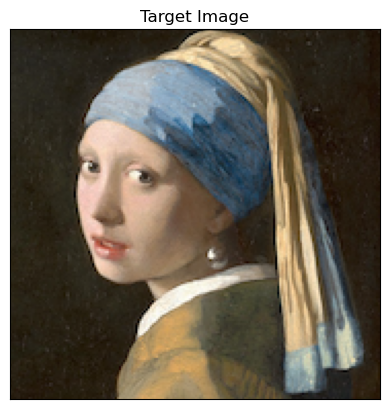

In [18]:
num_individuals = 100
num_genes = 100
tournament_size = 5
frac_elites = 0.2
frac_parents = 0.6
mutation_probability = 0.2
mutataion_type = "guided"

print("Summary of parameters")
print("Number of individuals: ", num_individuals)
print("Number of genes per individual: ", num_genes)
print("Tournament size: ", tournament_size)
print("Fraction of elites: ", frac_elites)
print("Fraction of parents: ", frac_parents)
print("Mutation probability: ", mutation_probability)
print("Mutation type: ", mutataion_type)

# load input image
target = cv2.imread("painting.png")
show_rgb_image(target, "Target Image")
image_size = (target.shape[1], target.shape[0])



In [19]:
# import time
# for i in range(10):
#     show_rgb_image(pop.individuals[i].draw(), "Initial Image")
#     time.sleep(1)

In [20]:
pop = Population(num_individuals, num_genes, image_size, frac_elites, frac_parents, tournament_size, target,guidance=mutataion_type)

from tqdm import tqdm
# iterate over generations
average_fitness = []
best_fitness = []


for i in tqdm(range(10000)):
    pop.evaluate()
    pop.selection()
    pop.crossover()
    pop.mutation(mutation_probability)
    pop.evaluate()
    #reset elite status
    for individual in pop.individuals:
        individual.elite = False
    # print("num individuals left",len(pop.individuals))
    average_fitness.append(pop.get_average_fitness())
    best_fitness.append(pop.get_best().fitness)
print("Generation: ", i, "Average fitness: ", pop.get_average_fitness(), "Best fitness: ", pop.get_best().fitness)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

Generation:  99 Average fitness:  -635615133.85 Best fitness:  -433450873


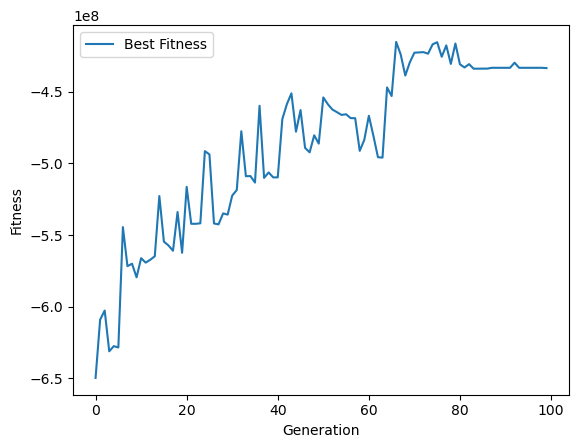

In [21]:
# plot the average and best fitness
# plt.plot(average_fitness, label="Average Fitness")
plt.plot(best_fitness, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend()
plt.show()


Best fitness:  -433450873


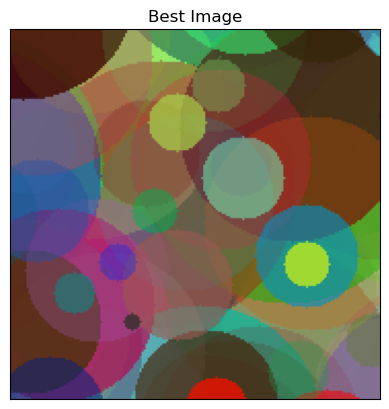

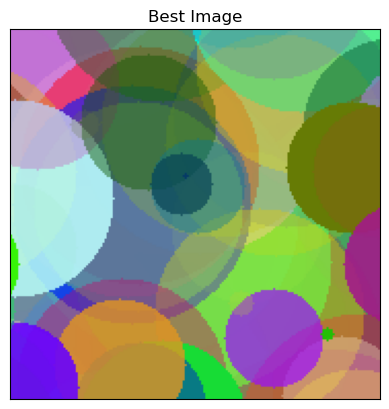

In [22]:
pop.evaluate()
pop.get_best()
print("Best fitness: ", pop.get_best().fitness)
show_rgb_image(pop.get_best().draw(), "Best Image")
show_rgb_image(pop.individuals[-1].draw(), "Best Image")

In [23]:
print("Number of individuals:", len(pop.individuals))

Number of individuals: 100


In [24]:
pop.individuals[0].chromosome


[[147, -36, 90, [27, 0, 141], 0.047571609786570046],
 [-60, 51, 90, [78, 88, 0], 0.9534706842631833],
 [128, 248, 90, [255, 128, 202], 0],
 [-3, 57, 90, [69, 106, 190], 0.3645328489904153],
 [81, -5, 89, [147, 142, 81], 0.6849219804256947],
 [93, 116, 87, [255, 77, 143], 0.182711331178604],
 [91, 54, 85, [0, 122, 87], 0.9114759813475088],
 [22, 116, 85, [0, 41, 95], 0.3268251756440392],
 [28, 166, 85, [13, 187, 0], 0.16040084505531177],
 [104, 224, 84, [112, 8, 0], 0],
 [261, 9, 83, [73, 3, 192], 0.3992654357510885],
 [101, 197, 82, [0, 0, 137], 0.6146657568092979],
 [-51, 180, 82, [25, 119, 198], 0.8727224783290155],
 [161, 111, 81, [0, 229, 33], 0.1877542374213873],
 [154, 21, 81, [63, 189, 0], 0.6875292778025773],
 [112, 181, 80, [81, 93, 217], 1],
 [115, 165, 79, [65, 27, 77], 0.22788634482372655],
 [243, 43, 78, [97, 223, 91], 1],
 [40, 157, 77, [0, 80, 76], 0],
 [111, 141, 77, [139, 224, 85], 0.3843600181637569],
 [11, 160, 76, [183, 0, 0], 0.10734666662261133],
 [32, 121, 74, [1

In [25]:
[x.fitness for x in pop.individuals]

[-433450873,
 -453693535,
 -457330508,
 -464194999,
 -469220152,
 -471347443,
 -471358741,
 -478975961,
 -480191181,
 -481164553,
 -481495707,
 -485998876,
 -487349155,
 -489089667,
 -490447349,
 -490654401,
 -490748980,
 -494137823,
 -497364202,
 -501176645,
 -509632325,
 -514769499,
 -533569290,
 -537437356,
 -538625667,
 -542945751,
 -543599040,
 -545704420,
 -548287983,
 -556925364,
 -557009476,
 -570485899,
 -571516886,
 -572036266,
 -576383387,
 -579428948,
 -580118617,
 -581180306,
 -589337875,
 -590740638,
 -591485393,
 -591975341,
 -592500302,
 -594115273,
 -595609279,
 -597929406,
 -598408192,
 -598509768,
 -608478189,
 -611588230,
 -614428491,
 -617994235,
 -620642064,
 -620780238,
 -622437026,
 -627273196,
 -630403181,
 -633066979,
 -634791113,
 -636303198,
 -636633958,
 -636867026,
 -637048045,
 -640173079,
 -642512981,
 -644114932,
 -648919965,
 -649201563,
 -651829250,
 -653394477,
 -653536274,
 -657878124,
 -658795800,
 -660263672,
 -691287720,
 -697027297,
 -700246700,

In [26]:

# # get the second index of the  all genes
# x = [x[1] for x in pop.individuals[0].chromosome]
# plt.hist(x, bins=20)

In [27]:
# # a white image
# image = np.ones((100, 100, 3), np.uint8)*255
# cv2.circle(image, (120, 120), 33, (0, 0, 255), -1)
# show_rgb_image(image)